##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Convolutional Variational Autoencoder

### Variational Autoencoder
The basic idea behind a variational autoencoder is that instead of mapping an input to fixed vector, input is mapped to a distribution. The only difference between the autoencoder and variational autoencoder is that bottleneck vector is replaced with two different vectors one representing the mean of the distribution and the other representing the standard deviation of the distribution.

<img src="1_dCy4DDqnP60gxrccMvxGTQ.jpeg">

Suppose that there exists some hidden variable z which generates an observation x.

<img src="Screen-Shot-2018-03-17-at-1.31.39-PM.png">

We can only see x, but we would like to infer the characteristics of z. In other words, we’d like to compute p(z|x).

$$
p\left( {z|x} \right) = \frac{{p\left( {x|z} \right)p\left( z \right)}}{{p\left( x \right)}}
$$

Unfortunately, computing p(x) is quite difficult.

$$
p\left( x \right) = \int {p\left( {x|z} \right)p\left( z \right)dz}
$$


This usually turns out to be an [intractable distribution.](https://stats.stackexchange.com/questions/4417/intractable-posterior-distributions) However, we can apply [varitational inference](https://arxiv.org/pdf/1601.00670.pdf) to estimate this value.

Let's approximate p(z|x) by another distribution q(z|x) which we'll define such that it has a tractable distribution. If we can define the parameters of q(z|x) such that it is very similar to p(z|x), we can use it to perform approximate inference of the intractable distribution.

KL divergence is a measure of difference between two probability distributions. Thus, if we wanted to ensure that q(z|x) was similar to p(z|x), we could minimize the KL divergence between the two distributions.

$$
\min KL\left( {q\left( {z|x} \right)||p\left( {z|x} \right)} \right)
$$

**minimizing the above also means maximizing the following:**

$$
{E_{q\left( {z|x} \right)}}\log p\left( {x|z} \right) - KL\left( {q\left( {z|x} \right)||p\left( z \right)} \right)
$$

The first term represents the reconstruction likelihood and the second term ensures that our learned distribution q is similar to the true prior distribution p.

In our graphical model, we can use q to infer the possible hidden variables (ie. latent state) which was used to generate an observation. We can further construct this model into a neural network architecture where the encoder model learns a mapping from x to z and the decoder model learns a mapping from z back to x.

<img src="Screen-Shot-2018-03-17-at-11.31.15-PM.png">

Our loss function for this network will consist of two terms, one which **penalizes reconstruction error** (which can be thought of maximizing the reconstruction likelihood as discussed earlier) and a second term which **encourages our learned distribution q(z|x) to be similar to the true prior distribution p(z)**, which we'll assume follows a unit Gaussian distribution, for each dimension j of the latent space.

$$
{\cal L}\left( {x,\hat x} \right) + \sum\limits_j {KL\left( {{q_j}\left( {z|x} \right)||p\left( z \right)} \right)}
$$

### Implementation

Rather than directly outputting values for the latent state as we would in a standard autoencoder, the encoder model of a VAE will output parameters describing a distribution for each dimension in the latent space. Since we're assuming that our prior follows a normal distribution, we'll output two vectors describing the mean and variance of the latent state distributions. If we were to build a true multivariate Gaussian model, we'd need to define a covariance matrix describing how each of the dimensions are correlated. However, we'll make a simplifying assumption that our covariance matrix only has nonzero values on the diagonal, allowing us to describe this information in a simple vector.

Our decoder model will then generate a latent vector by sampling from these defined distributions and proceed to develop a reconstruction of the original input.

<img src="Screen-Shot-2018-03-18-at-12.24.19-AM.png">

However, this sampling process requires some extra attention. When training the model, we need to be able to calculate the relationship of each parameter in the network with respect to the final output loss using a technique known as backpropagation. However, we simply cannot do this for a random sampling process. Fortunately, we can leverage a clever idea known as the **"reparameterization trick" which suggests that we randomly sample ε from a unit Gaussian, and then shift the randomly sampled ε by the latent distribution's mean μ and scale it by the latent distribution's variance σ.**



<img src="Reparameterization trick.jpg">



With this reparameterization, we can now optimize the parameters of the distribution while still maintaining the ability to randomly sample from that distribution.

<img src="Screen-Shot-2018-03-18-at-4.39.41-PM.png">

In order to deal with the fact that the network may learn negative values for σ, we'll typically have the network learn log σ and exponentiate this value to get the latent distribution's variance.

The main benefit of a variational autoencoder is that we're capable of learning smooth latent state representations of the input data. For standard autoencoders, we simply need to learn an encoding which allows us to reproduce the input. As you can see in the left-most figure, focusing only on reconstruction loss does allow us to separate out the classes (in this case, MNIST digits) which should allow our decoder model the ability to reproduce the original handwritten digit, but there's an uneven distribution of data within the latent space. In other words, there are areas in latent space which don't represent any of our observed data.

On the flip side, if we only focus only on ensuring that the latent distribution is similar to the prior distribution (through our KL divergence loss term), we end up describing every observation using the same unit Gaussian, which we subsequently sample from to describe the latent dimensions visualized. This effectively treats every observation as having the same characteristics; in other words, we've failed to describe the original data.

However, when the two terms are optimized simultaneously, we're encouraged to describe the latent state for an observation with distributions close to the prior but deviating when necessary to describe salient features of the input.


<img src="Screen-Shot-2018-03-18-at-7.22.24-PM.png">

In [2]:
# to generate gifs
#!pip install imageio

## Import TensorFlow and other libraries

This VAE has a modular design. The encoder, decoder and vae
are 3 models that share weights. After training vae,
the encoder can be used to  generate latent vectors.
The decoder can be used to generate MNIST digits by sampling the
latent vector from a gaussian dist with mean=0 and std=1.

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, Lambda
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import concatenate

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

Using TensorFlow backend.


#### Reparameterization trick

In [4]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Implements reparameterization trick by sampling
    from a gaussian with zero mean and std=1.
    Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    Returns:
        sampled latent vector (tensor)
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [5]:
def plot_results(models,
                 data,
                 y_label,
                 batch_size=128,
                 model_name="cvae_mnist"):
    """Plots 2-dim mean values of Q(z|X) using labels as color gradient
        then, plot MNIST digits as function of 2-dim latent vector
    Arguments:
        models (list): encoder and decoder models
        data (list): test data and label
        y_label (array): one-hot vector of which digit to plot
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "cvae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict([x_test, to_categorical(y_test)],
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.savefig(filename)
    plt.show()
    
    filename = os.path.join(model_name, "%05d.png" % np.argmax(y_label))
    # display a 10x10 2D manifold of the digit (y_label)
    n = 10
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict([z_sample, y_label])
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()


### Load MNIST dataset

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#### Reshape and normalize

In [7]:
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [8]:
# compute the number of labels
num_labels = len(np.unique(y_train))

# network parameters
input_shape = (image_size, image_size, 1)
label_shape = (num_labels, )
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 2
epochs = 30
num_layers = 2

# VAE model = encoder + decoder
# build encoder model

### Build a couple of dense input layers of the shape (28x28x1)
### and convert those to convolutional layers. 
### One layer is for the input shape and other is for labels

inputs = Input(shape=input_shape, name='encoder_input')
y_labels = Input(shape=label_shape, name='class_labels')
x = Dense(image_size * image_size)(y_labels)
x = Reshape((image_size, image_size, 1))(x)
x = concatenate([inputs, x])
for i in range(num_layers):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

### Allocate latent vector Q(z|X). The latent vectors will consist of
### mean and log variance layers

x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model([inputs, y_labels], [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='cvae_cnn_encoder.png', show_shapes=True)

# build decoder model



latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

### Take the shape of the encoder layers and build decoder layers
### These are transpose of convolutional (deconvolutional) layers

x = concatenate([latent_inputs, y_labels])
x = Dense(shape[1]*shape[2]*shape[3], activation='relu')(x)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(num_layers):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model([latent_inputs, y_labels], outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='cvae_cnn_decoder.png', show_shapes=True)

# instantiate vae model
outputs = decoder([encoder([inputs, y_labels])[2], y_labels])
cvae = Model([inputs, y_labels], outputs, name='cvae')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
class_labels (InputLayer)       [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 784)          8624        class_labels[0][0]               
__________________________________________________________________________________________________
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 28, 28, 1)    0           dense[0][0]                      
____________________________________________________________________________________________

W0319 15:25:37.897421 4557006272 network.py:1619] Model inputs must come from `tf.keras.Input` (thus holding past layer metadata), they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to "cvae" was not an Input tensor, it was generated by layer encoder_input.
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: encoder_input:0


In [9]:
import pandas as pd
args = pd.read_csv('arguments.csv',na_filter=True,nrows=1,na_values=None)

In [10]:
beta = args.loc[0,'beta']
mse = args.loc[0,'mse']
weights = args.loc[0,'weights']
digit = args.loc[0,'digit']

In [11]:
print(digit)

nan


W0319 15:25:38.012604 4557006272 training_utils.py:1152] Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.


CVAE
Model: "cvae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
class_labels (InputLayer)       [(None, 10)]         0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 77988       encoder_input[0][0]              
                                                                 class_labels[0][0]               
__________________________________________________________________________________________________
decoder (Model)                 (None, 28, 28, 1)    96449       encoder[1][2]            

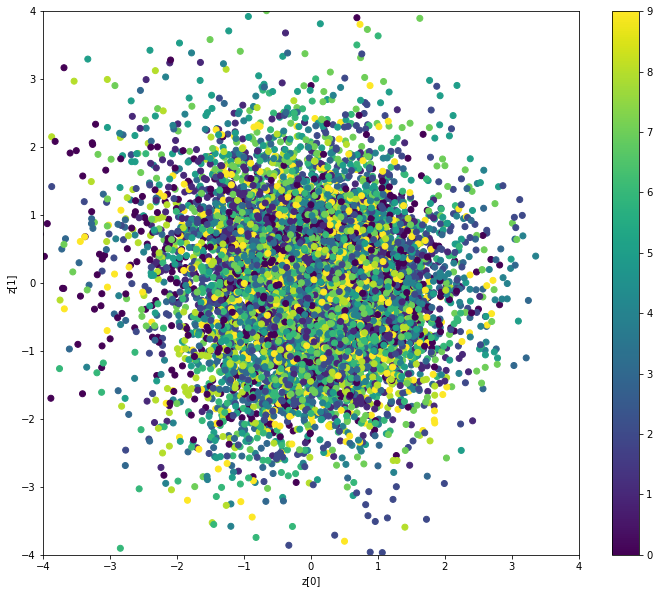

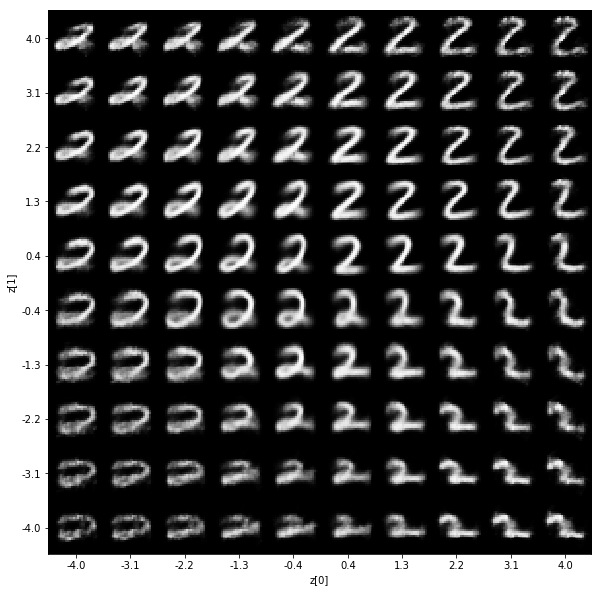

In [12]:
models = (encoder, decoder)
data = (x_test, y_test)

if np.isnan(beta) or beta < 1.0:
    beta = 1.0
    print("CVAE")
    model_name = "cvae_cnn_mnist"
else:
    print("Beta-CVAE with beta=", beta)
    model_name = "beta-cvae_cnn_mnist"

# VAE loss = mse_loss or xent_loss + kl_loss
if not np.isnan(mse):
    reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
else:
    reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                              K.flatten(outputs))

reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5 * beta
cvae_loss = K.mean(reconstruction_loss + kl_loss)
cvae.add_loss(cvae_loss)
cvae.compile(optimizer='rmsprop')
cvae.summary()
plot_model(cvae, to_file='cvae_cnn.png', show_shapes=True)

if weights:
    cvae = cvae.load_weights(weights)
else:
    # train the autoencoder
    cvae.fit([x_train, to_categorical(y_train)],
             epochs=epochs,
             batch_size=batch_size,
             validation_data=([x_test, to_categorical(y_test)], None))
    cvae.save_weights(model_name + '.h5')

if digit in range(0, num_labels):
    digit = np.array([digit])
else:
    digit = np.random.randint(0, num_labels, 1)

print("CVAE for digit %d" % digit)
y_label = np.eye(num_labels)[digit]
print(y_label)
plot_results(models,
             data,
             y_label=y_label,
             batch_size=batch_size,
             model_name=model_name)